# 1. loading datasets

Training has to be done with dropout as data is not always present

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import pandas as pd
from torch import nn 
import joblib
import numpy as np

# from common_utils import MLPBuilder
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.model_selection import train_test_split
modelname = 'DNN_model_[512, 512, 256, 512]'
modellayer = [512, 512, 256, 512]


In [438]:


print("PyTorch version:", torch.__version__)

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Current CUDA device index:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("No CUDA devices found.")
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



PyTorch version: 2.5.0+cu118
CUDA available: True
Current CUDA device index: 0
CUDA device name: NVIDIA GeForce RTX 4070 SUPER


In [439]:
# Update with the correct path
file_path = './Data/25-02-10/cleaned_df.csv'
# file_path = './Data/25-02-10/cleaned_df_features.csv'
model_path = './models/Grid_based'
cleaned_df = pd.read_csv(file_path)

In [440]:
cleaned_df

,Tx_0 RSSI,Tx_1 RSSI,Tx_2 RSSI,Tx_3 RSSI,Tx_4 RSSI,Tx_5 RSSI,Tx_6 RSSI,Tx_7 RSSI,X_Coord,Y_Coord
0,-61,-74,-79,127,-81,-78,127,-84,0,0
1,-61,-73,-78,-71,127,-78,127,127,0,0
2,-62,-75,-78,-72,-79,127,-84,127,0,0
3,-61,-73,-80,-71,-83,-78,127,127,0,0
4,-61,-75,-78,-71,-84,-78,-84,-86,0,0
...,...,...,...,...,...,...,...,...,...,...
6395,-79,-69,-81,-74,-70,-61,-78,-68,6,0
6396,-77,-69,-77,-71,-70,-61,-79,-67,6,0
6397,-77,-69,-81,-73,-70,-61,-79,-66,6,0
6398,-80,-69,-77,-72,-71,-61,-76,-67,6,0


In [441]:

# batt_columns = [col for col in cleaned_df.columns if 'Batt' in col]
# time_columns = [col for col in cleaned_df.columns if 'Time' in col]
# columns_to_drop = batt_columns+time_columns
# RSSI_columns = cleaned_df.drop(columns=columns_to_drop)


cleaned_df.shape

(6400, 10)

In [442]:
# cleaned_df

In [443]:
from common_utils import preprocess_dataset

# X = cleaned_df[['Tx_0 RSSI', 'Tx_1 RSSI', 'Tx_2 RSSI', 'Tx_3 RSSI', 'Tx_4 RSSI', 'Tx_5 RSSI', 'Tx_6 RSSI', 'Tx_7 RSSI', 'RSSI_Mean', 'RSSI_Variance', 'RSSI_Median']]
X = cleaned_df[['Tx_0 RSSI', 'Tx_1 RSSI', 'Tx_2 RSSI', 'Tx_3 RSSI', 'Tx_4 RSSI', 'Tx_5 RSSI', 'Tx_6 RSSI', 'Tx_7 RSSI']]


Y = cleaned_df[['X_Coord', 'Y_Coord']]

# Perform the train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Display the results
print("X_train:\n", X_train)
print("X_test:\n", X_test)
print("Y_train:\n", Y_train)
print("Y_test:\n", Y_test)

X_train:
       Tx_0 RSSI  Tx_1 RSSI  Tx_2 RSSI  Tx_3 RSSI  Tx_4 RSSI  Tx_5 RSSI  \
1859        -61        -68        -71        127        -70        -71   
3238        -75        -77        -80        -77        -60        -69   
5179        -76        127        -73        127        127        127   
2646        127        -73        -76        -71        -64        -52   
5676        127        -81        -66        -65        -73        -78   
...         ...        ...        ...        ...        ...        ...   
3772        -67        -70        127        -74        -78        127   
5191        -76        127        -72        127        -71        127   
5226        -77        127        -72        -78        127        127   
5390        -65        -61        -76        -80        -74        -72   
860         -57        -57        -67        127        127        -67   

      Tx_6 RSSI  Tx_7 RSSI  
1859        -82        -77  
3238        127        127  
5179        12

# 2. NN model

We will try to determine the optimal hyperparameters
1. Loss function
2. model depth and size, restricted to 3 layers

In [444]:
class MLPBuilder(nn.Module):

    def __init__(self, no_features, layers, no_labels = 64):
        super().__init__()
        layer_list = []
        
        # Input layer
        layer_list.append(nn.Linear(no_features, layers[0]))
        layer_list.append(nn.ReLU())
        layer_list.append(nn.Dropout(p=0.2))

        # Hidden layers
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            layer_list.append(nn.ReLU())
            layer_list.append(nn.Dropout(p=0.2))

        # Define the MLP stack as a sequential model
        self.mlp_stack = nn.Sequential(*layer_list)

        # Output layer, 1 outputs
        self.output_x = nn.Linear(layers[-1], 8) 
        self.output_y = nn.Linear(layers[-1], 8) 


        self._initialize_weights() 
        
    def forward(self, x):
        features = self.mlp_stack(x)
        logits_x = self.output_x(features)
        logits_y = self.output_y(features)
        return logits_x, logits_y
    
    def _initialize_weights(self):
        for layer in self.mlp_stack:
            if isinstance(layer, nn.Linear):
                # Use Kaiming initialization for ReLU activations
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

In [445]:
scaler_X = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

# Convert target data (grid indices) from DataFrame to NumPy arrays and then to tensors
Y_train_array = Y_train.to_numpy()  # Ensure these are NumPy arrays
Y_test_array = Y_test.to_numpy()

Y_train_tensor_x = torch.tensor(Y_train_array[:, 0], dtype=torch.long).to(device)
Y_train_tensor_y = torch.tensor(Y_train_array[:, 1], dtype=torch.long).to(device)

Y_test_tensor_x = torch.tensor(Y_test_array[:, 0], dtype=torch.long).to(device)
Y_test_tensor_y = torch.tensor(Y_test_array[:, 1], dtype=torch.long).to(device)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor_x, Y_train_tensor_y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create DataLoader for the test set
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor_x, Y_test_tensor_y)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [446]:
# We save the Scaler to load in during the evaluation
joblib.dump(scaler_X, model_path +'/scaler_X.pkl')

# scaler_X = joblib.load(model_path +'/scaler_X.pkl')

['./models/Grid_based/scaler_X.pkl']

In [447]:
def train_loop(dataloader, model, loss_fn_x, loss_fn_y, optimizer):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for inputs, targets_x, targets_y in dataloader:
        # Move data to the device
        inputs, targets_x, targets_y = inputs.to(device), targets_x.to(device), targets_y.to(device)

        optimizer.zero_grad()

        # Forward pass
        logits_x, logits_y = model(inputs)

        # Compute loss
        loss_x = loss_fn_x(logits_x, targets_x)
        loss_y = loss_fn_y(logits_y, targets_y)
        loss = loss_x + loss_y

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        preds_x = torch.argmax(logits_x, dim=1)
        preds_y = torch.argmax(logits_y, dim=1)
        correct = (preds_x == targets_x) & (preds_y == targets_y)  # Joint correctness
        total_correct += correct.sum().item()
        total_samples += inputs.size(0)
        total_loss += loss.item() * inputs.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples * 100
    return avg_loss, accuracy


def test_loop(dataloader, model, loss_fn_x, loss_fn_y):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets_x, targets_y in dataloader:
            inputs, targets_x, targets_y = inputs.to(device), targets_x.to(device), targets_y.to(device)

            logits_x, logits_y = model(inputs)

            loss_x = loss_fn_x(logits_x, targets_x)
            loss_y = loss_fn_y(logits_y, targets_y)
            loss = loss_x + loss_y

            preds_x = torch.argmax(logits_x, dim=1)
            preds_y = torch.argmax(logits_y, dim=1)
            correct = (preds_x == targets_x) & (preds_y == targets_y)
            total_correct += correct.sum().item()
            total_samples += inputs.size(0)
            total_loss += loss.item() * inputs.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples * 100
    return avg_loss, accuracy



In [448]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        """
        patience: number of epochs to wait for improvement in validation loss before stopping
        delta: minimum change to consider as an improvement
        """
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')  # Initialize the best loss as infinity
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset the counter if there's an improvement
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [449]:
import itertools

x = [64, 128, 256, 512]

# # Generate all combinations for each possible length (1 to 4 elements)
# combinations = []
# for r in range(1, 4):  # 1 to 3 layer configurations
#     combinations.extend(itertools.product(x, repeat=r))

# # Convert to list format and print
# combinations = [list(comb) for comb in combinations]
# print(combinations)

combinations = list(itertools.product(x, repeat=4))

# Convert to list format and print
combinations = [list(comb) for comb in combinations]
print(combinations)

[[64, 64, 64, 64], [64, 64, 64, 128], [64, 64, 64, 256], [64, 64, 64, 512], [64, 64, 128, 64], [64, 64, 128, 128], [64, 64, 128, 256], [64, 64, 128, 512], [64, 64, 256, 64], [64, 64, 256, 128], [64, 64, 256, 256], [64, 64, 256, 512], [64, 64, 512, 64], [64, 64, 512, 128], [64, 64, 512, 256], [64, 64, 512, 512], [64, 128, 64, 64], [64, 128, 64, 128], [64, 128, 64, 256], [64, 128, 64, 512], [64, 128, 128, 64], [64, 128, 128, 128], [64, 128, 128, 256], [64, 128, 128, 512], [64, 128, 256, 64], [64, 128, 256, 128], [64, 128, 256, 256], [64, 128, 256, 512], [64, 128, 512, 64], [64, 128, 512, 128], [64, 128, 512, 256], [64, 128, 512, 512], [64, 256, 64, 64], [64, 256, 64, 128], [64, 256, 64, 256], [64, 256, 64, 512], [64, 256, 128, 64], [64, 256, 128, 128], [64, 256, 128, 256], [64, 256, 128, 512], [64, 256, 256, 64], [64, 256, 256, 128], [64, 256, 256, 256], [64, 256, 256, 512], [64, 256, 512, 64], [64, 256, 512, 128], [64, 256, 512, 256], [64, 256, 512, 512], [64, 512, 64, 64], [64, 512, 64

In [450]:
import time
import torch.optim as optim
import torch.nn as nn

def determine_depth_and_width(layer_combinations, epochs):
    results = []  # Store results for all layer configurations
    training_times = []  # List to store training times

    for layers in layer_combinations:
        model = MLPBuilder(no_features=X_train.shape[1], layers=layers).to(device)
        criterion_x = nn.CrossEntropyLoss()  # Cross entropy loss for x-coordinate classification
        criterion_y = nn.CrossEntropyLoss()  # Cross entropy loss for y-coordinate classification
        l2_weight_decay = 1e-4
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_weight_decay)

        # Training loop
        print(f"{'=' * 50}\n"
              f"Layers: {layers}"
              )

        start_time = time.time()  # Start timing the training process

        for epoch in range(epochs):
            # Train the model
            train_loss, train_accuracy = train_loop(train_loader, model, criterion_x, criterion_y, optimizer)
            
            # Test the model
            test_loss, test_accuracy = test_loop(test_loader, model, criterion_x, criterion_y)

            # Print average loss and accuracy for the epoch
            print(f"Epoch: [{epoch + 1:>3}/{epochs:<3}]"
                  f"Train Loss: {train_loss:.6f}  |  Train Accuracy: {train_accuracy:.2f}%  |  "
                  f"Test Loss: {test_loss:.6f}  |  Test Accuracy: {test_accuracy:.2f}%\n")

            # Save results only for the last epoch
            if epoch == epochs - 1:
                results.append({
                    'layers': layers,
                    'train_loss': train_loss,
                    'train_accuracy': train_accuracy,
                    'test_loss': test_loss,
                    'test_accuracy': test_accuracy,
                })

        print(f"{'=' * 50}\n")

        end_time = time.time()  
        training_time = end_time - start_time  
        training_times.append(training_time) 

    return results, training_times

To determine the best layout configuration

In [451]:
epochs = 20
# results, training_times = determine_depth_and_width(combinations, epochs)

In [452]:
# test_accuracies = [result['test_accuracy'] for result in results]  
# layer_configs = [str(result['layers']) for result in results]  

# # Create a scatter plot for Test Accuracy vs. Training Time
# plt.figure(figsize=(10, 6))
# for i, layer_size in enumerate(layer_configs):
#     plt.scatter(training_times[i], test_accuracies[i], color='b')  # Plot point
#     plt.text(training_times[i], test_accuracies[i], layer_size, fontsize=9, ha='right')  # Add text label for each point

# # Adding labels and title
# plt.xlabel('Training Time (seconds)')
# plt.ylabel('Test Accuracy (%)')
# plt.title('Test Accuracy vs Training Time for Different Layer Configurations')

# plt.grid(True)
# plt.tight_layout()
# # plt.show()

# # # TODO changed when i get more data

In [453]:
# top_results = sorted(results, key=lambda x: x['test_accuracy'], reverse=True)[:5]

# # Print the top 5 configurations and their accuracies
# print("Top 5 Configurations and Test Accuracies:")
# for i, result in enumerate(top_results, start=1):
#     print(f"{i}. Layers: {result['layers']}, Test Accuracy: {result['test_accuracy']:.2f}%")

### The Best Model is seen to be [256,128,32] with the highest accuracy

## Evaluation of Model

In [454]:
import torch
import torch.optim as optim
import torch.nn as nn

# Model initialization
# model = MLPBuilder(no_features=X_train.shape[1], layers=[256, 512 , 256, 128])
model = MLPBuilder(no_features=X_train.shape[1], layers=modellayer).to(device)


# Use appropriate loss functions for classification
criterion_x = nn.CrossEntropyLoss()  # For x-coordinate
criterion_y = nn.CrossEntropyLoss()  # For y-coordinate
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping
early_stopping = EarlyStopping(patience=10, delta=0.001)

# Training parameters
best_modelepochs = 200
tr_loss, te_loss = [], []
tr_accuracy, te_accuracy = [],[]

for epoch in range(best_modelepochs):
    # Train and test the model
    train_loss, train_accuracy = train_loop(train_loader, model, criterion_x, criterion_y, optimizer)
    test_loss, test_accuracy = test_loop(test_loader, model, criterion_x, criterion_y)

    print(f"Epoch: [{epoch + 1:>3}/{best_modelepochs:<3}]"
          f"Train Loss: {train_loss:.6f} | Train Joint Accuracy: {train_accuracy:.2f}%  ||  "
          f"Test Loss: {test_loss:.6f} | Test Joint Accuracy: {test_accuracy:.2f}%\n")

    # Log losses
    tr_loss.append(train_loss)
    te_loss.append(test_loss)

    tr_accuracy.append(train_accuracy)
    te_accuracy.append(test_accuracy)

    # Early stopping check
    early_stopping(test_loss)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

# Save the model
torch.save(model.state_dict(), model_path+'/'+modelname+'.pth')
print("Model saved successfully.")


Epoch: [  1/200]Train Loss: 3.916654 | Train Joint Accuracy: 6.99%  ||  Test Loss: 3.757722 | Test Joint Accuracy: 10.86%

Epoch: [  2/200]Train Loss: 3.746559 | Train Joint Accuracy: 10.84%  ||  Test Loss: 3.739697 | Test Joint Accuracy: 12.03%

Epoch: [  3/200]Train Loss: 3.684773 | Train Joint Accuracy: 13.01%  ||  Test Loss: 3.697187 | Test Joint Accuracy: 13.05%

Epoch: [  4/200]Train Loss: 3.638877 | Train Joint Accuracy: 13.09%  ||  Test Loss: 3.660061 | Test Joint Accuracy: 13.67%

Epoch: [  5/200]Train Loss: 3.593457 | Train Joint Accuracy: 14.71%  ||  Test Loss: 3.613019 | Test Joint Accuracy: 14.84%

Epoch: [  6/200]Train Loss: 3.525725 | Train Joint Accuracy: 16.07%  ||  Test Loss: 3.523738 | Test Joint Accuracy: 17.34%

Epoch: [  7/200]Train Loss: 3.463691 | Train Joint Accuracy: 17.07%  ||  Test Loss: 3.491247 | Test Joint Accuracy: 17.97%

Epoch: [  8/200]Train Loss: 3.404099 | Train Joint Accuracy: 18.52%  ||  Test Loss: 3.435409 | Test Joint Accuracy: 19.92%

Epoch: [ 

In [455]:
print(model)

MLPBuilder(
  (mlp_stack): Sequential(
    (0): Linear(in_features=8, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
  )
  (output_x): Linear(in_features=512, out_features=8, bias=True)
  (output_y): Linear(in_features=512, out_features=8, bias=True)
)


In [456]:
model.eval()

# Choose a sample input from the test set
inputs, targets_x, targets_y = next(iter(test_loader))  # Get the first batch from the test_loader

# Select only the first 10 samples from the batch
inputs = inputs[:10]
actual_targets = torch.stack((targets_x[:10], targets_y[:10]), dim=1)  # Combine actual x and y coordinates

# Perform the forward pass
with torch.no_grad():
    logits_x, logits_y = model(inputs)  # Outputs from the model

    # For classification, use argmax to get the predicted class
    preds_x = torch.argmax(logits_x, dim=1)  # Predicted x-coordinates
    preds_y = torch.argmax(logits_y, dim=1)  # Predicted y-coordinates

# Combine predictions for display
predictions = torch.stack((preds_x, preds_y), dim=1)  # Shape: (10, 2)

# Print results
print("Predicted X and Y coordinates (grid indices):")
print(predictions.cpu().numpy())  # Convert to numpy for better readability

print("\nActual X and Y coordinates (grid indices):")
print(actual_targets.cpu().numpy())


Predicted X and Y coordinates (grid indices):
[[0 2]
 [7 1]
 [6 3]
 [3 5]
 [1 1]
 [5 4]
 [4 0]
 [0 3]
 [0 5]
 [4 1]]

Actual X and Y coordinates (grid indices):
[[0 2]
 [7 1]
 [6 3]
 [3 5]
 [1 1]
 [5 4]
 [4 0]
 [0 3]
 [0 5]
 [3 0]]


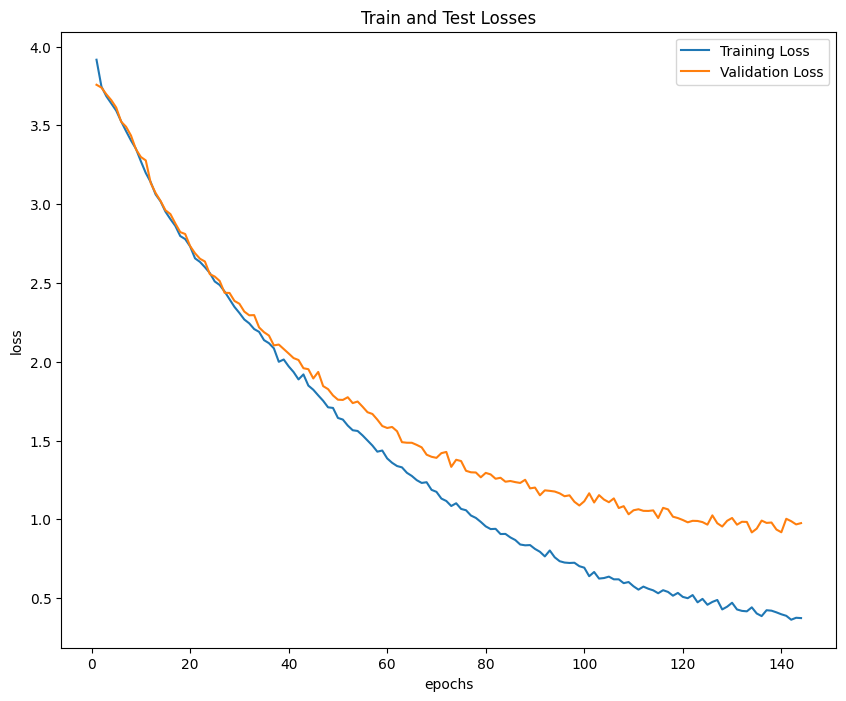

In [457]:

plt.figure(figsize=(10, 8))
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Training Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Validation Loss')


plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train and Test Losses')
plt.legend()

plt.show()
